<a href="https://colab.research.google.com/github/Viktor-Bello-Thomsen/MLFlow/blob/main/LSDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install influxdb

     |████████████████████████████████| 81kB 3.4MB/s 


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
####################################################
## Getting the data

from influxdb import InfluxDBClient # install via "pip install influxdb"
import pandas as pd

client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df

# Get the last 90 days of power generation data
generation = client.query(
    "SELECT * FROM Generation where time > now()-180d"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-180d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL


gen_df = get_df(generation)
wind_df = get_df(wind)


In [ ]:
#merge tables

from scipy import stats
import numpy as np
gen_df.dropna(inplace=True)
gen_df["Total"] = gen_df.rolling(60).mean()
normGen_df = gen_df.groupby(pd.Grouper(freq = "1H")).mean()
wind_df.dropna(inplace=True)
merged_df = wind_df.join(normGen_df)
merged_df.dropna(inplace=True)
merged_df = merged_df[merged_df["Total"] > 0]



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Total power generation'), Text(0.5, 0, 'Wind Speed')]

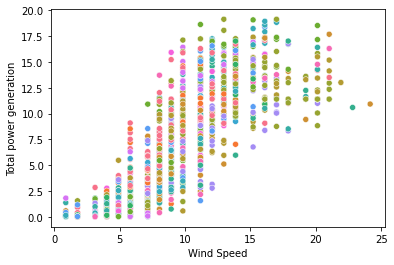

In [ ]:
import seaborn as sns
sns.scatterplot(merged_df["Speed"], merged_df["Total"], hue = merged_df["Direction"], legend=False).set(xlabel='Wind Speed', ylabel='Total power generation')

In [ ]:
idea = merged_df.groupby("Direction").mean()
idea["efficiency"] = idea["Total"]/idea["Speed"]
idea

,Source_time,Speed,ANM,Non-ANM,Total,efficiency
Direction,,,,,,
E,1.608288e+09,8.270240,6.601075,12.483698,6.491496,0.784922
ENE,1.607503e+09,7.489881,4.831500,10.681218,4.733763,0.632021
ESE,1.608480e+09,8.593102,7.101367,13.274313,7.141208,0.831040
N,1.608481e+09,8.394418,5.545290,11.484513,5.660478,0.674315
NE,1.606365e+09,9.131537,6.830474,10.895605,6.934607,0.759413
NNE,1.606986e+09,9.471660,5.650848,10.651959,5.565632,0.587609
NNW,1.608248e+09,9.152238,6.512635,11.492254,6.579830,0.718931
NW,1.606294e+09,7.953587,5.761278,10.318943,5.739010,0.721563
S,1.608901e+09,8.954555,7.712398,14.741021,7.786056,0.869508


In [ ]:
import numpy as np
winds = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]

dirDict = {dir:degree for dir, degree in zip(winds,np.linspace(0,360,len(winds)+1))}


def toRads(direction):
  return np.deg2rad(dirDict[direction]) 

def verticalConverter(direction):
  rads = toRads(direction)
  return np.cos(rads)
  
def horizontalConverter(direction):
  rads = toRads(direction)
  return np.sin(rads)
  

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
import pickle
class CCTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    return None
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X_cp = X.copy()
    #X_cp["Horizontal"] = X_cp["Direction"].apply(horizontalConverter) 
    #X_cp["Vertical"] = X_cp["Direction"].apply(verticalConverter)
    X_cp = X_cp.drop(["Direction", "Source_time", "Lead_hours"],axis = 1)
    return X_cp


col_transformer = ColumnTransformer([('poly', PolynomialFeatures(), ['Speed'])
                                    ],remainder='passthrough')


In [ ]:
####################################################
## Preprocess the data / Compose your pipeline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


Y = merged_df["Total"]
X = merged_df.drop(["Total", "ANM", "Non-ANM"], axis = 1)


X_train, X_test, Y_train, Y_test = train_test_split(X,Y, shuffle = False, test_size = 0.2, random_state = 42)

X_train

pipeline = Pipeline(steps=[
    ('custom_trans', CCTransformer()),
    ("col_trans", col_transformer),
    ('Scaling', StandardScaler()),
    ('linear_model', LinearRegression())
    ])



# Fit the pipeline

param_grid = {
    "col_trans__poly__degree" : [1,2,3,4,5],
    "col_trans__poly__interaction_only" : [True, False]
}

gsc = GridSearchCV(pipeline, param_grid = param_grid, scoring='neg_mean_squared_error',
            cv=TimeSeriesSplit(n_splits=int(X.shape[0]/((24*6)/3))).split(X_train,Y_train), verbose=4, n_jobs=-1, refit=True, return_train_score=True)

gsc.fit(X_train,Y_train)

#print(gsc.cv_results_)
print(gsc.best_score_)
#gsc.best_params_
gsc.best_estimator_.score(X_test, Y_test)

Fitting 26 folds for each of 10 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


-8.811726829786027


[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    4.2s finished


0.7210161664248238

Compare old model with current model

In [ ]:
#Load old model and compare with the new model
new_model = gsc.best_estimator_

try:
  old_model = pickle.load(open("gdrive/MyDrive/bestModelLSDA.sav", 'rb'))
  
  old_model_acc = old_model.score(X_test, Y_test)
  new_model_acc = new_model.score(X_test, Y_test)

  print("old models score", old_model_acc)
  print("new models score", new_model_acc)
  best_model = old_model if old_model_acc > new_model_acc else new_model

except:
  print("No previous model was found in the specified directory")
  best_model = new_model
  print("new models acc", new_model_acc)
pickle.dump(best_model, open("gdrive/MyDrive/bestModelLSDA.sav", 'wb'))


old models acc -4.258295365926984
new models acc 0.7266537387001952


Load new Data and create predictions

In [ ]:

# Load stored model and compare with newly trained
# and store the best one

####################################################
## Do forecasting with the best one

# Get all future forecasts regardless of lead time
forecasts  = client.query(
    "SELECT * FROM MetForecasts where time > now()"
    ) # Query written in InfluxQL
for_df = get_df(forecasts)

# Limit to only the newest source time
newest_source_time = for_df["Source_time"].max()
newest_forecasts = for_df.loc[for_df["Source_time"] == newest_source_time].copy()

# Preprocess the forecasts and do predictions in one fell swoop
# using your best pipeline.
newest_forecasts["pred"] = best_model.predict(newest_forecasts)
newest_forecasts.drop(["Lead_hours", "Source_time"], axis = 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


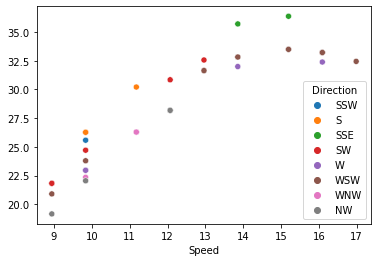

In [ ]:
import seaborn as sns

sns.scatterplot(newest_forecasts["Speed"], gsc.predict(newest_forecasts), hue =newest_forecasts["Direction"] )

